In [46]:
import numpy as np
import os, re, time
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.stem.snowball import SpanishStemmer
from sklearn.decomposition import PCA
import pylab

pylab.rcParams['figure.figsize'] = (14, 14) # Tamaño de los plots

# Introducción

El modelo de Skip-gram fue propuesto por Mikolov, Chen, Corrado y Dean para obtener representaciones vectoriales semánticamente significativas de un conjunto dado de palabras dado [1]. Consiste en un modelo neuronal que toma una palabra como entrada y dispone como salida el contexto de dicha palabra, teniendo una capa oculta cuyo propósito es codificar la palabra de entrada en un embedding. Tras entrenar sobre un conjunto basto de pares palabra-contexto, sacados previamente de un corpus dado, los embeddings obtenidos suelen tener propiedades significativas para representar a las palabras en diversas tareas de Machine Learning como por ejemplo el clustering de palabras.

En esta práctica se nos presentó con dos problemas distintos y con la tarea de basarnos en el modelo de Skip-gram para resolverlos. En el primer problema se nos da un conjunto de 100 documentos y el objetivo es obtener un embedding de cada uno, utilizando un modelo donde la entrada sea el índice de un documento y la salida sean los índices de las palabras presentes en dicho documento. En el segundo problema se nos da un conjunto de palabras en una lengua A, y sus traducciones en una lengua B, y el objetivo es obtener embeddings para las palabras de la lengua A utilizando un modelo que tome como entrada un índice de una palabra de la lengua A y como salida los índices de las palabras de la lengua B que sean sus traducciones.

# TODO:
- número de iteraciones y learning rate pequeño
- Función de pérdida y evaluaciones

# Modelo neuronal

In [50]:
class One2Vec():
    """
    Clase para utilizar el modelo neuronal inspirado en el modelo de skipgram
    para obtener embeddings de palabras (word2vec)
    
    Como en skipgram se entiende que la entrada de este modelo neuronal es un
    vector one-hot-encoding, que tiene solamente ceros excepto en una posición
    específica.
    
    Sin embargo, en este modelo que usamos, el tamaño del vector de salida
    no necesariamente tiene que ser del mismo tamaño que el de entrada, ya que
    aquí no estamos relacionando palabras del mismo vocabulario para obtener
    embeddings.
    """
    
    def __init__(self, dim_in, dim_out, dim_embedding = 100):
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dim_embedding = dim_embedding
        
        self.W = np.random.random((dim_in, dim_embedding))
        self.U = np.random.random((dim_embedding, dim_out))
        
    def hotencoding(self, index, size):
        """
        Devuelve un vector de ceros de tamaño "size"
        con un solo 1 en la posición indicada por index.
        
        :param index: entero
        :param size: entero
        :returns arreglo
        """
        v = np.zeros(size)
        v[index] = 1
        return v
    
    def fit(self, X, Y, epochs = 1000, initial_learning_rate = .1, ending_learning_rate = 0.001):
        """
        Realiza el entrenamiento del modelo.
        
        :param X: lista de enteros. Cada entero representa el indice del dato de
            entrada al que se asocia la salida.
            
        :param Y: lista de listas de enteros. Del mismo tamaño que X. Y[i] es el
            conjunto de indices de salida asociados a X[i]
            
        :param epochs: entero. Número de iteraciones que se harán sobre todo el
            dataset.
            
        :param initial_learning_rate: flotante
        
        :param ending_learning_rate: flotante. El learning rate decrece en cada
        iteración de manera lineal hasta llegar a este valor.
        
        :returns Nada
        """
        inicio = time.time()
        
        learning_rate_delta = (initial_learning_rate - ending_learning_rate)/(epochs - 1)
        learning_rate = initial_learning_rate
        for epoch in range(epochs):
            loss = 0
            for j, x in enumerate(X):
                # Feedforward:
                salida1 = self.W[x]
                salida2 = np.dot(self.U.T, salida1)
                salida_softmax = np.exp(salida2 - np.max(salida2))/np.sum(np.exp(salida2 - np.max(salida2))) # se debe restar el máximo para evitar overflows
                
                # Backpropagation:
                vector_error = np.sum([salida_softmax - self.hotencoding(c, self.dim_out) for c in Y[j]], axis = 0)
                self.W[x] -= learning_rate * np.dot(self.U, vector_error)
                self.U -= learning_rate * np.outer(salida1, vector_error)
                
                loss -= np.sum(np.log(salida_softmax)[Y[j]])
            
            learning_rate -= learning_rate_delta
            
            if epoch % (epochs // 4) == 0 or epoch == epochs -1:
                print("Época: {0} - Tiempo: {1:.2f} mins.".format(epoch + 1, (time.time() - inicio) /60 ))
                print("\tLoss:", loss/len(Y))
                self.evaluate(X, Y)
                print()
    
    def predict(self, x):
        """
        Devuelve la salida que se activa en la red dado un indice de entrada.
        
        :param x: entero.
        
        :returns vector de salida. Es una distribución de probabilidad, debido
            a que se aplica softmax.
        """
        salida = np.dot(self.U.T, self.W[x])
        return np.exp(salida - np.max(salida))/np.sum(np.exp(salida - np.max(salida)))
    
    def get_embeddings(self):
        """
        Devuelve los embeddings aprendidos por la red.
        El renglón "i" representa el embedding del elemento
        de entrada "i"
        
        :returns matriz de embeddings
        """
        return self.W
    
    def _cross_entropy(self, p, q):
        """
        Función auxiliar. Dados dos vectores p y q representando distribuciones
        de probabilidad, devuelve la entropía cruzada de ambos.
        
        Si q tiene algún elemento igual a 0, esta función devuelve un error.
        
        :param p: arreglo. Distribución de probabilidad que se toma como "ground truth"
        :param q: arreglo. Distribución de probabilidad estimada.
        :returns flotante: entropía cruzada de p y q
        """
        return - np.dot(p, np.log(q))
    
    def evaluate(self, X, Y):
        """
        Dado un conjunto de datos (X, Y), se calcula la entropía cruzada
        de evaluar cada entrada en el modelo y compararla con la que
        debería ser la distribución de salida. Y también calcular
        un error en la distribución promedio.
        
        :param X: lista de indices de entrada
        :param Y: lista de listas de indices de contexto de salida
        :returns Nada
        """
        suma_entropia = 0
        suma_punto = 0
        for i in range(len(X)):
            y = self.hotencoding(Y[i], self.dim_out)
            y_estimada = self.predict(X[i])

            suma_punto += 1 - np.dot(y, y_estimada)
            suma_entropia += self._cross_entropy(y /np.max(y), y_estimada)

        print("\tEntropia Cruzada promedio:", suma_entropia / len(X))
        print("\tError en la distrib promedio (producto punto):", suma_punto / len(X))

# Funciones Auxiliares

In [14]:
def word2index():
    """
    Devuelve un defaultdict que sirve para asociar una palabra (string)
    a un indice.
    """
    dicc = defaultdict()
    dicc.default_factory = lambda: len(dicc)
    return dicc

def create_index2word(word2index):
    """
    Dado un diccionario word2index, devuelve otro diccionario
    que asocia un indice a una palabra.
    """
    index2word = dict()
    for k, v in word2index.items():
        index2word[v] = k
    return index2word

In [15]:
def plot_words(Z,ids):
    """
    Plotea el conjunto de datos Z añadiendo las etiquetas dispuestas en ids
    
    :param Z: arreglo bidimensional.
    :param ids: lista de strings. Del mismo tamaño que Z[0]
    """
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    plt.show()

# Ejercicio 1: Índice de documento a palabras

En este ejercicio se nos dan 100 documentos de texto, y se nos pide encontrar embeddings para cada uno. Para ello se entrenará el modelo considerando como entrada el índice del documento, y como salida el conjunto de índices de las palabras que aparecen en el documento.

Primero, leemos la información directamente desde los archivos del corpus para así obtener el vocabulario de salida, asociar un índice a cada palabra de dicho vocabulario, una lista de listas con los indices de las palabras presentes en cada documento, y una lista con los nombres de los documentos

In [16]:
corpus1dir = "./datasets/CorpusDocs"

word2index1 = word2index() # contendrá al vocabulario de salida, asociando una palabra a su indice
stemizador = SpanishStemmer() # Para hacer stemming
docs = [] # lista de listas, donde docs[i] tiene la lista de indices de las palabras del documento #i
docs_titles = [] # lista de titulos

r = re.compile("[^\W\d]+") # Filtramos digitos y cualquier tipo de puntuación

for textfile in os.listdir(corpus1dir):
    with open(os.path.join(corpus1dir, textfile), "r") as inputf:
        doc = []
        for line in inputf:
            tokens = r.findall(line)
            for token in tokens:
                doc.append(word2index1[stemizador.stem(token)])

        docs_titles.append(textfile)
        docs.append(list(set(doc)))

index2word1 = create_index2word(word2index1) # asociará un índice a una palabra del vocabulario de salida

In [58]:
print("Número de documentos leídos:", len(docs))
print("Tamaño del vocabulario de salida:", len(word2index1))
print()

doc_n = 1 # Documento a  mostrar como ejemplo
print("Documento Ejemplo:", docs_titles[doc_n])
print(" ".join([index2word1[t] for t in docs[doc_n]]))

Número de documentos leídos: 100
Tamaño del vocabulario de salida: 8202

Documento Ejemplo: sacarosa (2).txt
de la es que el los conoc y las segu human un sobr cuerp produc una comun descompon par impuls baj al com su se a en o principal nuestr indic funcion con mas no pued termin form gener much exces aliment sacar apropi describ azuc dos azucar simpl glucos fructos hidrat carbon complej independient endulz ofrec consumidor energ hay tip moren marron blanc propiedad incolor inodor sabor dulc fin da rap ferment absorb humed leer usos edulcor fuent ceb product bellez limpiez jardin dar volum pes person carbohidrat sangr proporcion obtien cañ nos remolach llam azucarer melaz riesg salud calor obes cari dental glucem alto diabet consum cantidad diet peligr consult medic condicion durant embaraz pequeñ le aport obten tom grand necesit gras manteng contribu exist tien tod combin utiliz conserv


Para entrenar el modelo hicimos varias pruebas, y llegamos a la conclusión de que lo mejor era usar 100 épocas y un learning rate inicial muy pequeño de 0.005

In [20]:
# ENTRENANDO EL MODELO:
ndocs = len(docs)
nwords = len(word2index1)
X1 = list(range(len(docs)))

model1 = One2Vec(ndocs, nwords, dim_embedding = 100)
model1.fit(X1, docs, epochs = 100, initial_learning_rate = .005)

Época: 0 - Minutos Transcurridos: 0.03034287691116333
	Entropia promedio: 2625.622959554639
	Error en la distrib promedio (producto punto): 0.8412878064980849
	Loss: 2854.6645090645366

Época: 10 - Minutos Transcurridos: 0.3208244760831197
	Entropia promedio: 2374.1616554441302
	Error en la distrib promedio (producto punto): 0.7233309619058916
	Loss: 2387.2435059357226

Época: 20 - Minutos Transcurridos: 0.6589861909548441
	Entropia promedio: 2302.627374694144
	Error en la distrib promedio (producto punto): 0.6611264694059642
	Loss: 2315.5000492810004

Época: 30 - Minutos Transcurridos: 1.001514458656311
	Entropia promedio: 2215.7970488525157
	Error en la distrib promedio (producto punto): 0.5701567738894382
	Loss: 2229.114920789348

Época: 40 - Minutos Transcurridos: 1.3368090987205505
	Entropia promedio: 2124.3096563362014
	Error en la distrib promedio (producto punto): 0.4689023324845882
	Loss: 2136.781077530283

Época: 50 - Minutos Transcurridos: 1.6761911074320475
	Entropia promed

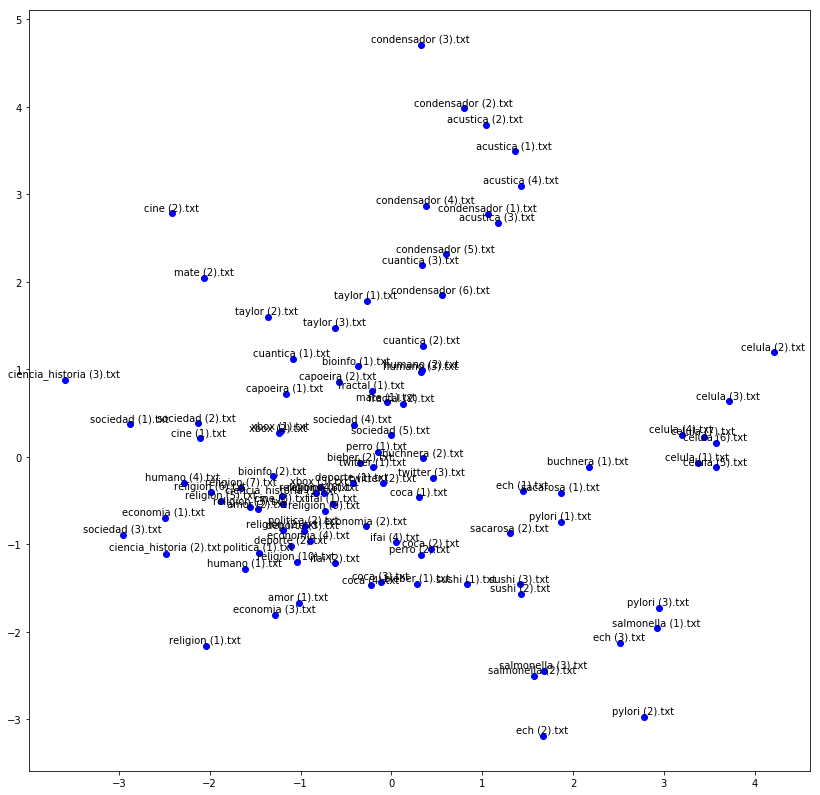

In [47]:
# PLOTEANDO LOS RESULTADOS
pca = PCA(n_components=2)
embeddings2D = pca.fit_transform(model1.get_embeddings())
plot_words(embeddings2D, docs_titles)

Como se puede observar, parece ser que si se forman algunos clústers de los documentos que están relacionados.

# Ejercicio 2: Palabras de una lengua a otra

En este ejercicio se nos dió un archivo de texto que contenía un conjunto de palabras de una lengua (que llamamos "Lengua A"), y un conjunto de traducciones a otra lengua (que llamamos "Lengua B"). El propósito es obtener embeddings de las palabras la lengua A, entrenando el modelo con las traducciones en la Lengua B como salida de la red.

Primero leemos el archivo original y de ahí obtenemos un diccionario de traducciones, así como los diccionarios correspondientes de los vocabularios de cada lengua que asocien una palabra a un índice y viceversa.

In [22]:
inputfile2 = "./datasets/graph.txt"

traducciones = defaultdict(list) # diccionario que asocia las palabras de la lengua A con las palabras de la lengua B
word2index2A = word2index() # diccionario que asocia cada palabra de la lengua A con su índice
word2index2B = word2index() # diccionario que asocia cada palabra de la lengua B con su índice

with open(inputfile2, "r") as inputf:
    palabras_relacionadas = []
    for line in inputf:
        if line[0] == '\t':
            traducciones[currindexA].append(word2index2B[line.strip()])
        else:
            currindexA = word2index2A[line.strip()]
            traducciones[currindexA] = []
            
index2word2A = create_index2word(word2index2A) # diccionario que asocia un índice con su palabra correspondiente de la lengua A
index2word2B = create_index2word(word2index2B) # diccionario que asocia un índice con su palabra correspondiente de la lengua B

In [62]:
print("Número de Palabras en la Lengua A:", len(index2word2A))
print("Número de Palabras en la Lengua B:", len(index2word2B))
print()

print("Algunas palabras de la lengua A:")
print(", ".join([index2word2A[index] for index in list(traducciones.keys())[:100]]), " ... ")
print()

print("Algunas traducciones:")
for palabraA in list(traducciones.keys())[:10]:
    palabrasB = [index2word2B[indexb] for indexb in traducciones[palabraA]]
    print(index2word2A[palabraA], ":", ", ".join(palabrasB))

Número de Palabras en la Lengua A: 929
Número de Palabras en la Lengua B: 1339

Algunas palabras de la lengua A:
a, abasto, ablandar, abono, abrazar, abuela, abuelita, abuelo, acabado, acabar, aceite, acercar, acocil, acomodar, acostar, activar, adentro, afortunadamente, afuera, agarrar, agregar, agrio, agua, agua.caliente, agua.fría, aguantar, aguardiente, agujerear/a, ah, ahora, ahí, ajolote, al, al.instante, ala, albañil, alcanzar, alegrar, alejar, alfalfa, algo, alimentar, alimento, aliviar, allá, allí, almorzar, alrededor, alzar, amamantar, amanecer, amenazar, amiga, amontonar, ancho, andar, animal, animal.de.Dios, antes, aparecer, apenas, aplastar, apostillar, aprender, apurar, aquí, arrebatar, arreglar, arreglo, arriba, arroz, asado, asentar, asiento, asustarse, así, así.es.que, atacar, atascadera, atormentar, atrio, atrás, aunque, aventar, ay, ayer, ayudar, ayunar, ayuntamiento, año, años, bailar, baile, bajar, barreno, barrer, barril, bastante, batir, bautizar  ... 

Algunas t

Para el este modelo, tras hacer pruebas descubrimos que .025 era un buen learning rate, y que se podían hacer más de 1000 iteraciones sin problemas. Sin embargo, también notamos que después de 100 iteraciones las métricas de desempeño cambian poco.

In [52]:
# Creando el dataset:
X2 = []
Y2 = []
for palabraA, palabrasB in traducciones.items():
    X2.append(palabraA)
    Y2.append(palabrasB)

# Entrenando el modelo:
npalabrasA = len(index2word2A)
npalabrasB = len(index2word2B)
model2 = One2Vec(npalabrasA, npalabrasB, dim_embedding = 100)
model2.fit(X2, Y2, epochs = 1000, initial_learning_rate = .025)

Época: 0 - Tiempo: 0.01 mins.
	Loss: 12.253326572257597
	Entropia promedio: 10.84770970695646
	Error en la distrib promedio (producto punto): 0.99821270826063

Época: 62 - Tiempo: 0.65 mins.
	Loss: 0.8817272675587413
	Entropia promedio: 0.8794325750772019
	Error en la distrib promedio (producto punto): 0.049030878873749066

Época: 124 - Tiempo: 1.38 mins.
	Loss: 0.8441755402853018
	Entropia promedio: 0.8438261940525377
	Error en la distrib promedio (producto punto): 0.023103434368658787

Época: 186 - Tiempo: 2.16 mins.
	Loss: 0.8359755169054955
	Entropia promedio: 0.8358699469325245
	Error en la distrib promedio (producto punto): 0.01722620173688398

Época: 248 - Tiempo: 2.88 mins.
	Loss: 0.8337021586556251
	Entropia promedio: 0.8336887345554449
	Error en la distrib promedio (producto punto): 0.015609519354219104

Época: 249 - Tiempo: 2.90 mins.
	Loss: 0.8336930659892268
	Entropia promedio: 0.8336808319121581
	Error en la distrib promedio (producto punto): 0.01560365772406702



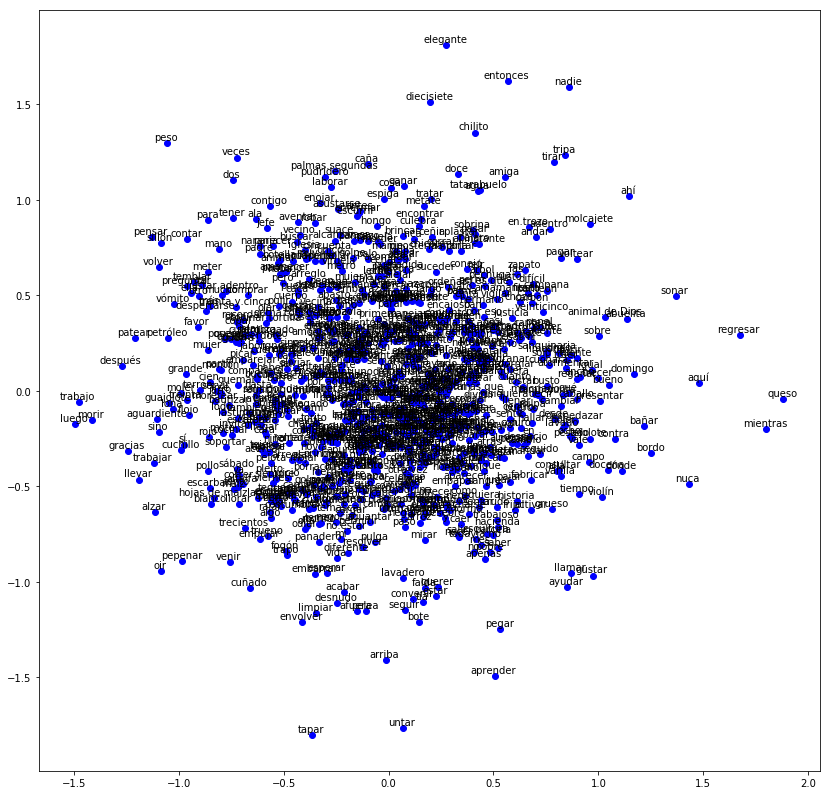

In [55]:
palabras = [index2word2A[x] for x in X2]
pca = PCA(n_components=2)
embeddings2D = pca.fit_transform(model2.get_embeddings())
maxw = None
plot_words(embeddings2D[:maxw], palabras[:maxw])

# Conclusiones y comentarios
## Ejercicio 1:
- 